In [61]:
import os
import analysis_utils as au
import quick_metadata_plots as qmplt
import padeopsIO as pio
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
keylab = pio.budgetkey.key_labels()
from pathlib import Path
import random
import imageio
import shutil

from pyspod.spod.standard import Standard as spod_standard
import pyspod.spod.utils as utils_spod

import modred as mr

data_folder = "/Users/sky/src/HowlandLab/data"

In [62]:
def get_clean_data(file_name, data_folder = "/Users/sky/src/HowlandLab/data"):
    with xr.open_dataset(os.path.join(data_folder, file_name)) as ds:
        ds = ds.isel(time = slice(100, None))
    return ds

In [63]:
def plot_u(ds, t_idx, mean_val = 1):
    da = ds.u
    range_val = np.max(np.abs(mean_val - da))  # centered at 1
    fig = plot_field(da.isel(time = t_idx), mean_val - range_val, mean_val + range_val, "Streamwise Velocity", keylab['u'])
    return fig

def plot_p(ds, t_idx):
    da = ds.p
    range_val = np.max(np.abs(da))
    fig = plot_field(da.isel(time = t_idx), -range_val, range_val, "Streamwise Pressure", keylab['p'])
    return fig

def plot_vals(arr, min_val, max_val, title, label):
    fig = plot_field(arr, min_val, max_val, title, label)
    return fig

def plot_field(da, min_val, max_val, title, label):
    colormap = "bwr"
    fig, ax = plt.subplots(1, 1, dpi = 300)
    # plot velocity
    im = da.imshow(ax = ax, cmap = colormap, vmin = min_val, vmax = max_val, cbar = False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(axis='both', which='major', labelsize=12)
    cbar.set_label(label, fontsize=14)
    ax.set_title(title, size = 16)
    ax.set_xlabel(keylab['x'], size = 14)
    ax.set_ylabel(keylab['z'], size = 14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout()
    return fig

def ms2fps( ms ):
    ''' Converts milliseconds to frames per second '''
    return 1000 / ms

def animate_field(ds, frame_function, anim_path, fps = 10, loop = False, **kwargs):
    # make a temporary directory
    fp_out = Path( anim_path ).resolve()
    fp_out_base = fp_out.stem
    dir_out = fp_out.parents[0]
    randstr = str(random.randint(1000000, 9999999) )
    dir_tmp = dir_out / f'xanim_tmp_{fp_out_base}.{randstr}'
    os.mkdir(dir_tmp)
    # plot data
    ntimes = len(ds.time)
    ndigits = len(str(ntimes))
    fp_list = []
    for i in range(ntimes):
        # try:
        fig = frame_function(ds, i, **kwargs)
        idx_str = str(i).zfill(ndigits)
        fn_out_ii = dir_tmp / f'xanim_tmpfile_{idx_str}.png'
        fig.savefig(fn_out_ii, dpi = 300)
        fp_list.append( dir_tmp / fn_out_ii )
        plt.close(fig)
        # except:
        #     break
    print(fp_list)
    frames = []
    for ii in range(ntimes):
        image = imageio.v2.imread(fp_list[ii])
        frames.append(image)

    duration = ms2fps( fps )
    imageio.mimsave(fp_out, frames, duration = duration, loop = loop)    
    shutil.rmtree(dir_tmp)


In [64]:
def get_u_pod_modes(ds, num_modes, **kwargs):
    return get_pod_modes(ds.u, num_modes, label = keylab['u'], **kwargs)

def get_p_pod_modes(ds, num_modes, **kwargs):
    return get_pod_modes(ds.p, num_modes, label = keylab['p'], **kwargs)

def get_pod_modes(da, num_modes, label = "", avg_val = None, plot = True, tidx = 0, **kwargs):
    da = da.transpose("x", "z", "time")
    da_mean = da.mean(dim = "time")
    da_prime = da - da_mean
    vecs = np.array(da_prime)
    nx, nz, nt = vecs.shape
    vecs = vecs.reshape(nx * nz, nt)
    POD_res = mr.compute_POD_arrays_snaps_method(vecs, list(mr.range(num_modes)))
    modes = POD_res.modes.reshape(nx, nz, num_modes)
    eigvals = POD_res.eigvals
    proj_coeffs = POD_res.proj_coeffs[0:num_modes, tidx]
    reconstruct = da_mean + np.sum([proj_coeffs[i] * modes[:, :, i] for i in range(modes.shape[2])], axis = 0)
    if plot:
        modes = POD_res.modes.reshape(nx, nz, num_modes)
        eigvals = POD_res.eigvals
        proj_coeffs = POD_res.proj_coeffs[0:num_modes, tidx]
        plot_pod_modes(modes, eigvals, label, avg_val, **kwargs)
        plot_reconstruction(reconstruct, **kwargs)
    return POD_res, reconstruct

def plot_pod_modes(modes, eigvals, label, avg_val, mode_path = None, **kwargs):
    nmodes = modes.shape[2]
    ncols = 2
    nrows = math.ceil(nmodes / ncols)
    fig, axes = plt.subplots(nrows, ncols, dpi = 300, figsize = (8, 6), sharex=True, sharey = True)
    if avg_val is None:
        avg_val = np.average(modes[1:5, :, :])
    range_val = np.max(np.abs(modes - avg_val))
    r, c = 0, 0
    e1 = eigvals[0]
    for i in range(nmodes):
        imode = modes[:, :, i]
        iax = axes[r, c]
        im = iax.imshow(imode.transpose(), cmap='bwr', vmin = avg_val - range_val, vmax = avg_val + range_val, extent=[-5,20,-2.5,2.5])
        iax.set_title(f"$\lambda_{i + 1} / \lambda_1$ = " + str(round(eigvals[i] / e1, ndigits=3)), size = 14)
        if c == 0:
            iax.set_ylabel(keylab['z'], size = 12)
        if r == nrows - 1:
            iax.set_xlabel(keylab['x'], size = 12)
        iax.tick_params(axis='both', which='major', labelsize=10)
        c += 1
        if c == ncols:
            c = 0
            r += 1
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.01, 0.25, 0.01, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(axis='both', which='major', labelsize=12)
    cbar.set_label(label, fontsize=14)
    fig.tight_layout()
    if mode_path is not None:
        fig.savefig(mode_path, dpi = 300)
    return

def plot_reconstruction(reconstruct, recon_path = None, **kwargs):
    fig = plot_field(reconstruct, min_val=0, max_val=2, title = "Reconstructed Streamwise Velocity", label = keylab["u"]);
    if recon_path is not None:
        fig.savefig(recon_path, dpi = 300)
    return

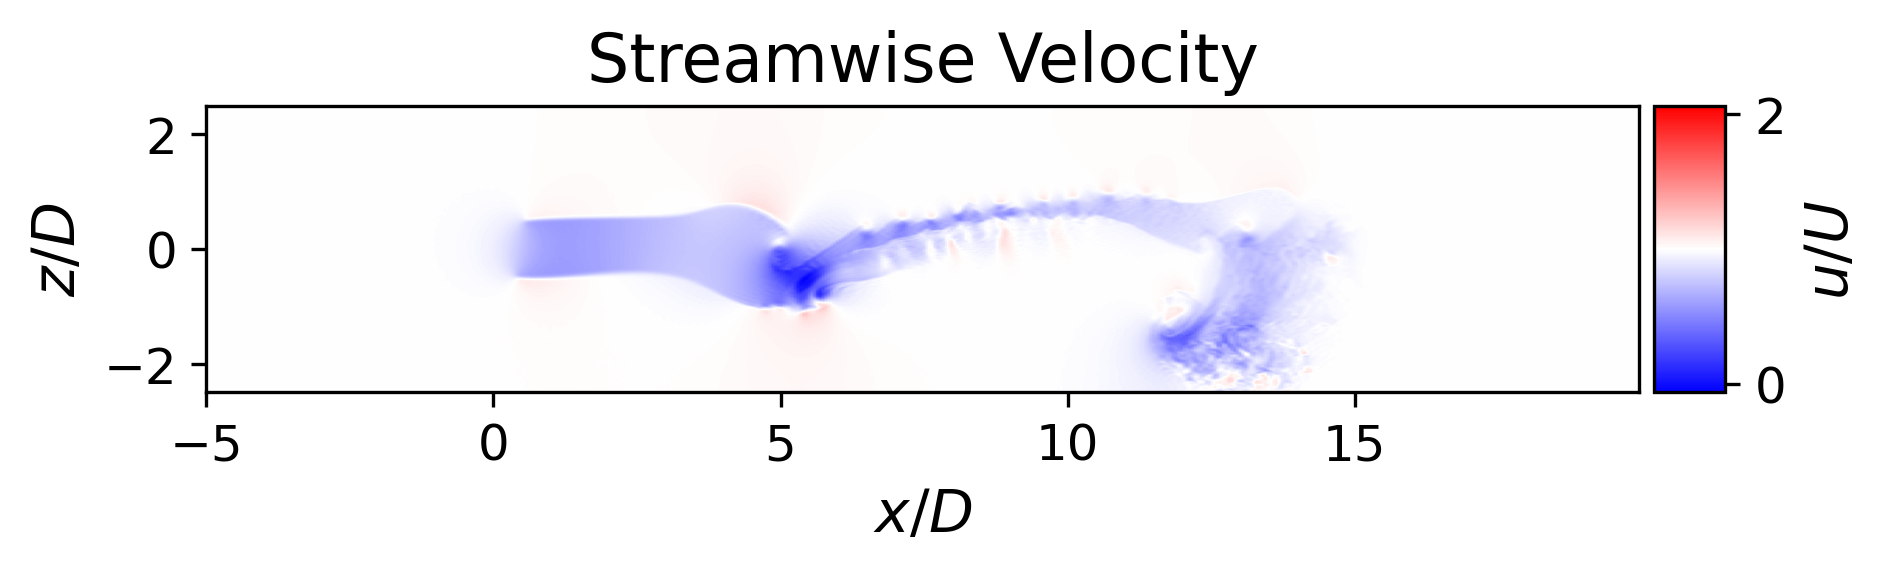

In [65]:
ds5 = get_clean_data("run05_data.nc")
tidx = 250
plot_u(ds5, tidx, mean_val=1);

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_59044/268514525.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


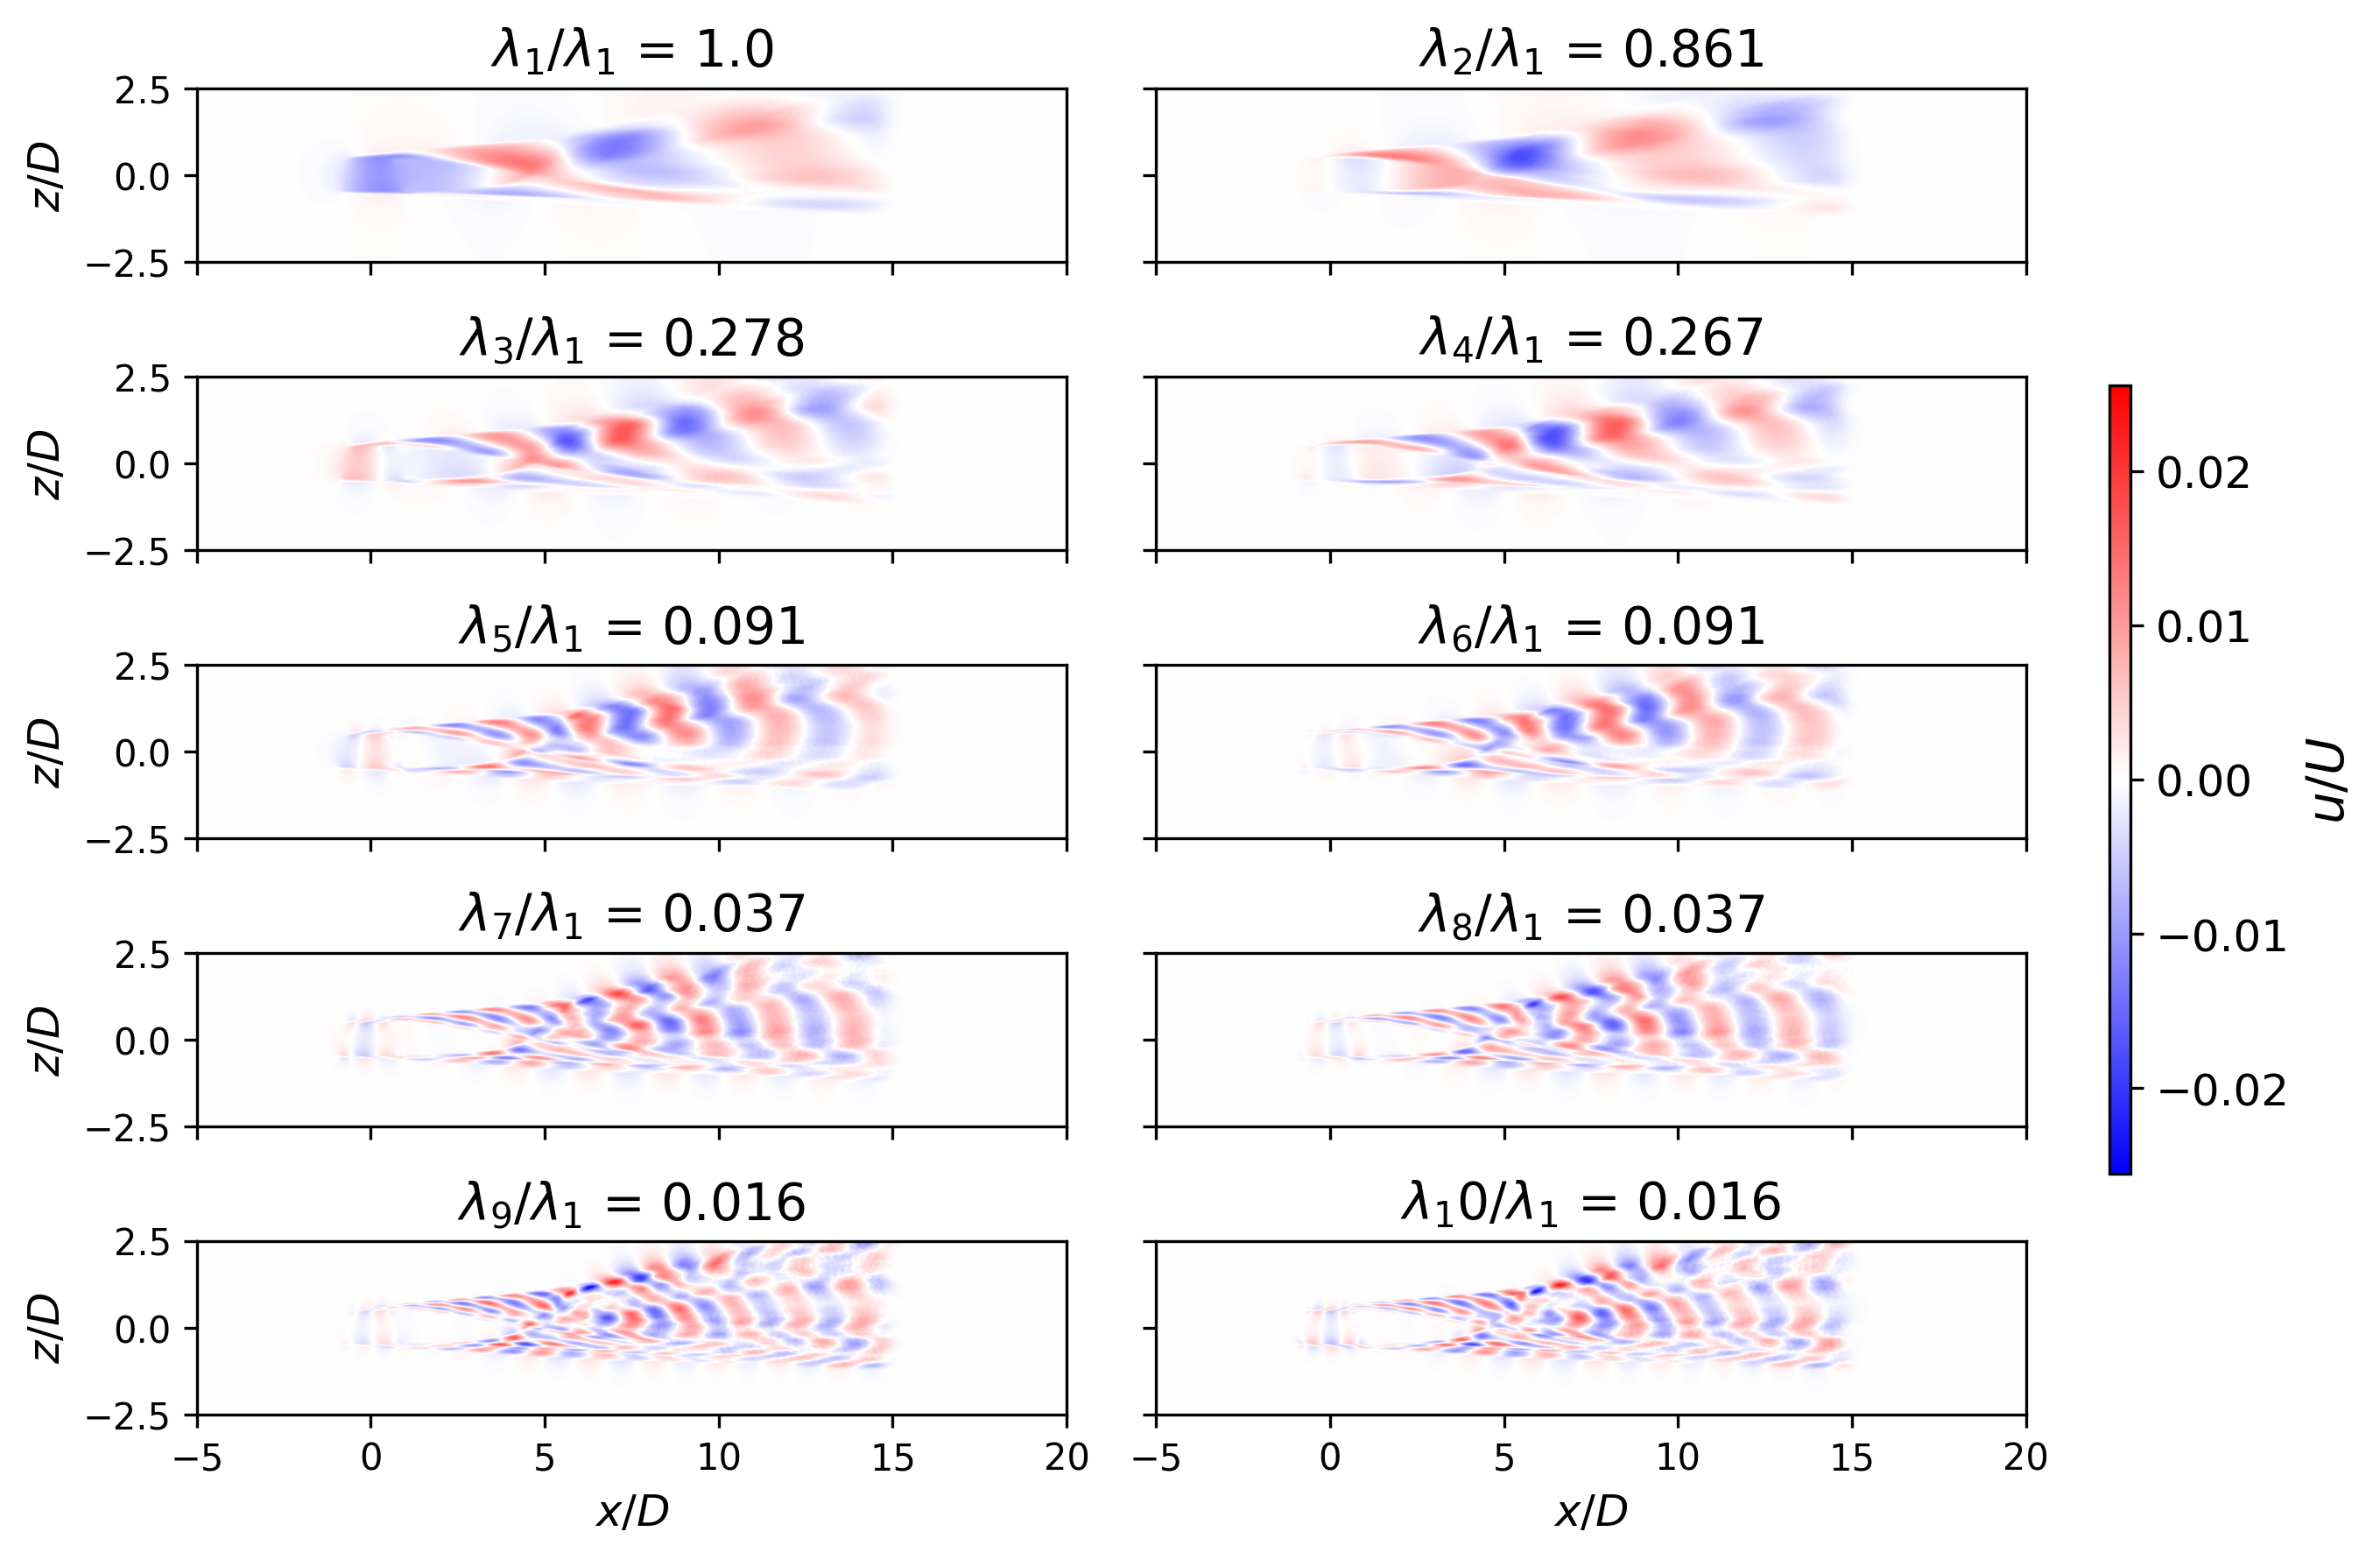

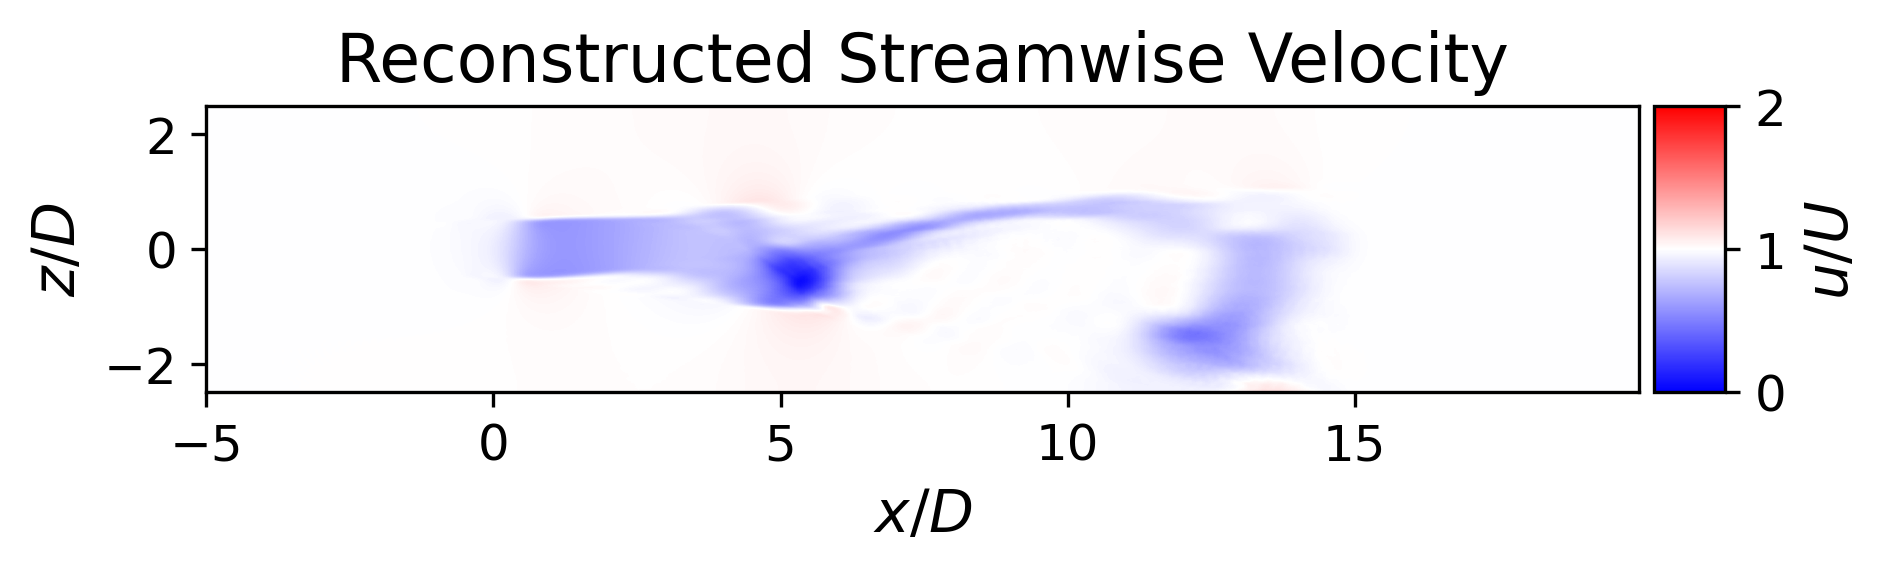

In [84]:
nmodes = 10
POD_res, reconstruct = get_u_pod_modes(ds5, nmodes, tidx = tidx, mode_path = os.path.join(data_folder, "pod_5.png"), recon_path = os.path.join(data_folder, "recon_5.png"))

In [85]:
mse = (np.square(ds5.u[tidx, :, :] - reconstruct)).mean()
mse.values * 100

np.float64(0.0539152705286969)

In [67]:
# ntstep = len(ds_prime["time"])
# modes_1, eigenvals_1 = get_u_pod_modes(ds_prime.isel(time = slice(round(ntstep / 2), None)), 8, plot_path = os.path.join(data_folder, "pod_5.png"), plot = False)

In [68]:
# ntstep = len(ds_prime["time"])
# modes_2, eigenvals_2 = get_u_pod_modes(ds_prime.isel(time = slice(round(ntstep / 4), None)), 8, plot_path = os.path.join(data_folder, "pod_5.png"), plot = False)

In [69]:
params = {"time_step":0.011, "n_space_dims":2, "n_variables":1, "n_dft":50, "overlap":50, "mean_type":"longtime", "n_modes_saved":8}

spod = standard.fit(data_list=ds_prime.u)
spod.plot_eigs_vs_frequency()

NameError: name 'standard' is not defined

In [ ]:
f1, f1_idx = spod.find_nearest_freq(freq_req=2 * math.pi * 0.1, freq=spod.freq)
spod.plot_2d_modes_at_frequency(freq_req=f1, freq=spod.freq, modes_idx=[0,1,2], x1=ds_prime.x, x2=ds_prime.z, equal_axes=True)

# Laminar Flow

I began by exploration with laminar flows at a medium resolution of (nx, ny, nz) = (256, 128, 128). I also started with a high amplitude and frequency of movemement with frequency $f = 1$ for all moving turbines and amplitude of $A = 0.5$ for surging turbines and $A = 5^\circ$ for pitching turbines.

## Stationary Turbine

In [ ]:
stationary_ds  = get_clean_data("stationary_data_r_256_t_0.nc")

In [ ]:
plot_u(stationary_ds, 1)

In [ ]:
plot_p(stationary_ds, 1800)

## Surging Turbine

In [ ]:
surging_ds  = get_clean_data("surging_data_r_256_t_0.nc")

In [ ]:
plot_u(surging_ds, 1800)

In [ ]:
plot_p(surging_ds, 1800)

In [ ]:
modes, eigenvals = get_u_pod_modes(surging_ds, 6)

In [ ]:
modes, eigs = get_p_pod_modes(surging_ds, 4)

In [ ]:
params = {"time_step":0.062, "n_space_dims":2, "n_variables":1, "n_dft":50, "overlap":50, "mean_type":"longtime", "n_modes_saved":6}

In [ ]:
standard  = spod_standard(params=params, comm=None)
spod = standard.fit(data_list=surging_ds.u)

In [ ]:
spod.plot_eigs()

In [ ]:
spod.plot_eigs_vs_frequency()

In [ ]:
f1, f1_idx = spod.find_nearest_freq(freq_req=2 * math.pi, freq=spod.freq)
spod.plot_2d_modes_at_frequency(freq_req=f1, freq=spod.freq, modes_idx=[0,1,2], x1=surging_ds.x, x2=surging_ds.z, equal_axes=True)

## Pitching Turbine

In [ ]:
pitching_ds = get_clean_data("pitching_data_r_256_t_0.nc")

In [ ]:
plot_u(pitching_ds, 1800)

In [ ]:
plot_p(pitching_ds, 1800)

In [ ]:
modes, eigenvals = get_u_pod_modes(pitching_ds, 6)

In [ ]:
modes, eigenvals = get_p_pod_modes(pitching_ds, 6)

In [ ]:
spod = standard.fit(data_list=pitching_ds.u)

In [ ]:
spod.plot_eigs_vs_frequency()

## Surging and Pitching Turbine

In [ ]:
surging_pitching_ds = get_clean_data("surging_pitching_data_r_256_t_0.nc")

In [ ]:
plot_u(surging_pitching_ds, 1800)

In [ ]:
plot_p(surging_pitching_ds, 1800)

In [ ]:
modes, eigenvals = get_u_pod_modes(surging_pitching_ds, 6)

In [ ]:
modes, eigenvals = get_p_pod_modes(surging_pitching_ds, 6)